In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# take a SQL query as an argument and returns a pandas dataframe
db = 'chinook.db'
def run_query(q):
    with sqlite3.connect(db) as conn:
        return pd.read_sql(q, conn)

# run SQL queries that don't return tables    
def run_command(c):
    with sqlite3.connect(db) as conn:
        conn.isolation_level = None 
        conn.execute(c)
        
# return a list of all tables and views in the database
def show_tables(c):
    table_list = run_query(c)
    print(table_list)

In [2]:
q ="""
SELECT name,type
FROM sqlite_master
WHERE type IN ('table','view')
"""
show_tables(q)

                      name   type
0                    album  table
1                   artist  table
2                 customer  table
3                 employee  table
4                    genre  table
5                  invoice  table
6             invoice_line  table
7               media_type  table
8                 playlist  table
9           playlist_track  table
10                   track  table
11           country_count   view
12             new_country   view
13  customer_count_country   view
14          update_country   view


In [3]:
q ="""
SELECT DISTINCT(name) 
FROM genre 
LIMIT 5
"""
run_query(q)

,name
0,Rock
1,Jazz
2,Metal
3,Alternative & Punk
4,Rock And Roll


In [4]:
q ="""
SELECT * 
FROM album 
LIMIT 3
"""
run_query(q)

,album_id,title,artist_id
0,1,For Those About To Rock We Salute You,1
1,2,Balls to the Wall,2
2,3,Restless and Wild,2


In [5]:
albums_to_purchase = """

WITH usa_tracks_sold AS
   (
    SELECT il.* FROM invoice_line il
    INNER JOIN invoice i on il.invoice_id = i.invoice_id
    INNER JOIN customer c on i.customer_id = c.customer_id
    WHERE c.country = "USA"
   )

SELECT g.name,
       count(uts.invoice_line_id) tracks_sold,
       CAST(count(uts.invoice_line_id) AS float) / 
                  (SELECT COUNT(*) from usa_tracks_sold
                   ) percentage_sold
     FROM usa_tracks_sold uts
     LEFT JOIN track t ON t.track_id = uts.track_id
     LEFT JOIN genre as g ON g.genre_id = t.genre_id
     GROUP BY 1
     ORDER BY 2 DESC
     LIMIT 10
     
     """
df=run_query(albums_to_purchase)

In [6]:
print(df)

                 name  tracks_sold  percentage_sold
0                Rock          561         0.533777
1  Alternative & Punk          130         0.123692
2               Metal          124         0.117983
3            R&B/Soul           53         0.050428
4               Blues           36         0.034253
5         Alternative           35         0.033302
6               Latin           22         0.020932
7                 Pop           22         0.020932
8         Hip Hop/Rap           20         0.019029
9                Jazz           14         0.013321


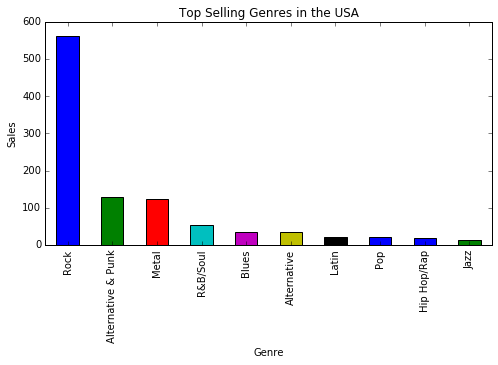

In [7]:
plt.figure(figsize=(8, 4))
ax = df.tracks_sold.plot(kind='bar')
ax.set_xlabel('Genre')
ax.set_ylabel('Sales')
ax.set_xticklabels(df.name)
plt.title('Top Selling Genres in the USA')

Among the four genres in question, top best selling genre, **Punk(#2)**, **Blues(#5)**, **pop (#9)** are among the top ten most popular ones.  Thus, Red bb Tone, Slim Jim Bites and Meteor and the Girls should be choosen.

In [8]:
# analyzing employee sales performance
q="""
SELECT e.first_name || ' ' || e.last_name Employee_name,
       SUM(i.total) toal_sale
FROM employee e
LEFT JOIN customer c ON e.employee_id=c.support_rep_id
INNER JOIN invoice i ON i.customer_id = c.customer_id
GROUP BY Employee_name
"""
df = run_query(q)
print(df)

   Employee_name  toal_sale
0   Jane Peacock    1731.51
1  Margaret Park    1584.00
2  Steve Johnson    1393.92


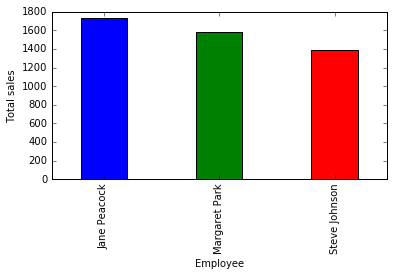

In [9]:
plt.figure(figsize=(6, 3))
ax = df.toal_sale.plot(kind='bar', width=0.4)
ax.set_xlabel('Employee')
ax.set_ylabel('Total sales')
ax.set_xticklabels(df.Employee_name)

### analyzing sales by country

In [10]:
sales_by_country = '''
WITH country_or_other AS
    (
     SELECT
       c.customer_id,
       CASE
           WHEN (
                 SELECT count(*)
                 FROM customer
                 where country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
    )

SELECT
    country,
    customers,
    total_sales,
    avg_val_cuatomer,
    avg_order
FROM
    (
    SELECT
        country,
        count(distinct customer_id) customers,
        SUM(unit_price) total_sales,
        SUM(unit_price) / count(distinct customer_id) avg_val_cuatomer,
        SUM(unit_price) / count(distinct invoice_id) avg_order,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM country_or_other
    GROUP BY country
    ORDER BY sort ASC, total_sales DESC
    );
'''
run_query(sales_by_country)

,country,customers,total_sales,avg_val_cuatomer,avg_order
0,USA,13,1040.49,80.037692,7.942672
1,Canada,8,535.59,66.948750,7.047237
2,Brazil,5,427.68,85.536000,7.011148
3,France,5,389.07,77.814000,7.781400
4,Germany,4,334.62,83.655000,8.161463
5,Czech Republic,2,273.24,136.620000,9.108000
6,United Kingdom,3,245.52,81.840000,8.768571
7,Portugal,2,185.13,92.565000,6.383793
8,India,2,183.15,91.575000,8.721429
9,Other,15,1094.94,72.996000,7.448571


In [11]:
df=run_query(sales_by_country)
df = df[0:9]
df1 = df[['country', 'customers']]
df2 = df[['country', 'total_sales']]
df3 = df[['country', 'avg_val_cuatomer']]
df4 = df[['country', 'avg_order']]

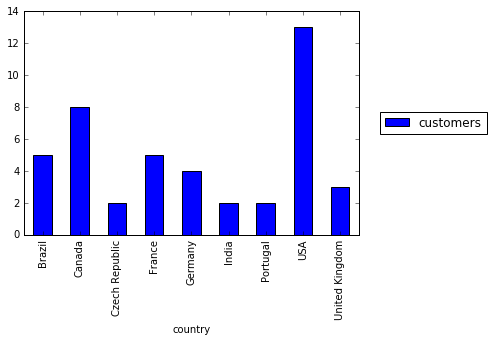

In [12]:
pivoted = pd.pivot_table(df1, index='country')
pivoted.plot(kind='bar', width=0.5)
plt.legend(loc='center right', bbox_to_anchor=(1.4, 0.5))

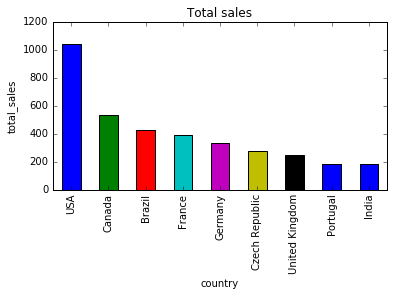

In [13]:
plt.figure(figsize=(6, 3))
ax = df2.total_sales.plot(kind='bar')
ax.set_xlabel('country')
ax.set_ylabel('total_sales')
ax.set_xticklabels(df2.country)
ax.set_title('Total sales')

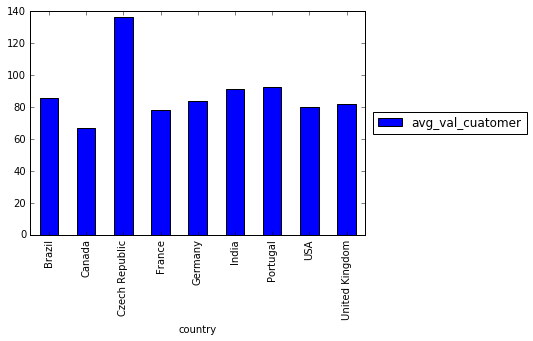

In [14]:
pivoted = pd.pivot_table(df3, index='country')
pivoted.plot(kind='bar', width=0.5)
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))

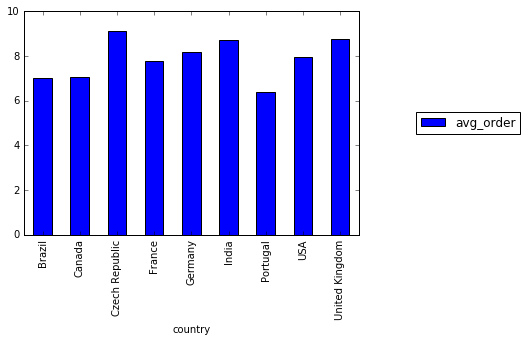

In [15]:
pivoted = pd.pivot_table(df4, index='country')
pivoted.plot(kind='bar', width=0.5)
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
# More customers did not associate with more sales. Czech has the least customer base for growth. Brazil has the second best sales per customer record.

Based on the low customer base and sales, Czech, India, Portugal and UK are potenital markets for expansion.

### analysis of albums vs individual tracks

In [16]:
# tracks per invoice_line
q="""
SELECT invoice_line_id
FROM invoice_line
WHERE (SELECT COUNT(track_id)
        FROM invoice_line 
        GROUP BY invoice_line_id) != 1
"""
run_query(q)

,invoice_line_id


In invoice_line table, each invoice_line_id is associated with 1 track_id. Left join it with invoice table and then inner join with track to __get tracks and associated album_id per purchase__. 

In [17]:
# info on invoice_id, track_id and album_id
q="""
SELECT i.invoice_id, t.track_id, t.album_id
FROM invoice i
LEFT JOIN invoice_line il ON il.invoice_id = i.invoice_id
INNER JOIN track t ON t.track_id = il.track_id
ORDER BY i.invoice_id
LIMIT 5
"""
run_query(q)

,invoice_id,track_id,album_id
0,1,1158,91
1,1,1159,91
2,1,1160,91
3,1,1161,91
4,1,1162,91


In [18]:
# info on tracks per album
q="""
SELECT album_id, track_per_album
FROM (SELECT album_id, COUNT(track_id) track_per_album
      FROM track
      GROUP BY album_id)
LIMIT 5
"""
run_query(q)

,album_id,track_per_album
0,1,10
1,2,1
2,3,3
3,4,8
4,5,15


In track table, each album_ids is associated with at least 1 track_id.  comaring tracks associated with an album and tracks in the invoice_line using set operation to determine whether it was a album purchase or individual purchase.  

In [19]:
q = """
WITH invoice_first_track AS
    (SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1)

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / 
        (SELECT COUNT(*) FROM invoice) percent
FROM 
(SELECT
     ifs.invoice_id,
     ifs.first_track_id,
     CASE
         WHEN
          (SELECT t.track_id FROM track t
            WHERE t.album_id = (SELECT t2.album_id FROM track t2
                                WHERE t2.track_id = ifs.first_track_id) 
        EXCEPT 
            SELECT il2.track_id FROM invoice_line il2
            WHERE il2.invoice_id = ifs.invoice_id
          ) IS NULL
        AND
            (SELECT il2.track_id FROM invoice_line il2
             WHERE il2.invoice_id = ifs.invoice_id
            EXCEPT 
              SELECT t.track_id FROM track t
              WHERE t.album_id =(SELECT t2.album_id FROM track t2
                                 WHERE t2.track_id = ifs.first_track_id) 
            ) IS NULL
                  
         THEN "yes"
         ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs)
GROUP BY album_purchase;
"""
run_query(q)

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668


Most of the purchases are from track selections, suggeting letting customer to pick their songs of choice might make more business sense.

### Which artist is used in the most playlists

In [21]:
# need to link artist, album, track, playlist_track and playlist tables
q="""
SELECT a.name artist_name, 
       COUNT(p.playlist_id) playlist_total
FROM artist a
INNER JOIN album al ON al.artist_id = a.artist_id
INNER JOIN track t ON t.album_id = al.album_id
INNER JOIN playlist_track pt ON pt.track_id = t.track_id
INNER JOIN playlist p ON p.playlist_id = pt.playlist_id
GROUP BY artist_name
ORDER BY playlist_total DESC
LIMIT 3

"""
run_query(q)

,artist_name,playlist_total
0,Iron Maiden,516
1,U2,333
2,Metallica,296


### Which artists contribute to the most popular playlists?

In [42]:
q="""
WITH new_table AS
    (SELECT a.name,
            p.playlist_id,
            t.album_id,
            il.invoice_line_id
    FROM playlist p
    INNER JOIN playlist_track pt ON pt.playlist_id = p.playlist_id
    INNER JOIN track t ON t.track_id = pt.track_id
    INNER JOIN invoice_line il ON il.track_id = t.track_id
    INNER JOIN album al ON al.album_id = t.album_id
    INNER JOIN artist a ON a.artist_id = al.artist_id)
     
SELECT name artist_name,
        playlist_id,
        COUNT(invoice_line_id) Number_purchased
FROM new_table
GROUP BY playlist_id
ORDER BY number_purchased DESC
LIMIT 3
"""
run_query(q)

,artist_name,playlist_id,Number_purchased
0,Emerson String Quartet,1,4754
1,Emerson String Quartet,8,4754
2,The King's Singers,5,1852


### How many tracks have been purchased vs not purchased?

In [41]:
q="""
WITH purchased AS
    (SELECT t.track_id,
            CASE WHEN il.invoice_line_id IS NOT NULL THEN 'Yes'
                 ELSE 'No'
            END AS track_purchased
     FROM track t
     LEFT JOIN invoice_line il ON il.track_id = t.track_id)
      
SELECT track_purchased,
       COUNT(*) numbers_purchased
FROM purchased
GROUP BY track_purchased
"""
run_query(q)

,track_purchased,numbers_purchased
0,No,1697
1,Yes,4757


###  Do protected vs non-protected media types have an effect on popularity?

In [39]:
q="""
WITH media_bought AS
    (SELECT t.track_id, 
            m.name media_name,
            il.invoice_line_id,
            CASE WHEN m.name LIKE 'Protected%' THEN 'Yes'
                 ELSE 'No'
            END as 'protected'
     FROM track t
     INNER JOIN media_type m ON m.media_type_id = t.media_type_id
     INNER JOIN invoice_line il ON il.track_id = t.track_id)
     
SELECT protected,
       COUNT(invoice_line_id) purchased
FROM media_bought
GROUP BY protected
"""
run_query(q)

,protected,purchased
0,No,4315
1,Yes,442
